# Set up example code

## Model setup

In [1]:
import subprocess

import surmise

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from scipy.linalg import lapack
from scipy import stats
import emcee
import numpy as np

import importlib

import os
import dill as pickle
from pathlib import Path

import src.reader as Reader

## Step 1: prepare input pickle file

### Load stuff from text files

In [2]:
# Read data files
RawData1 = Reader.ReadData('input/Example/Data_PHENIX_AuAu200_RAACharged_0to10_2013.dat')
RawData2 = Reader.ReadData('input/Example/Data_PHENIX_AuAu200_RAACharged_40to50_2013.dat')
RawData3 = Reader.ReadData('input/Example/Data_ATLAS_PbPb2760_RAACharged_0to5_2015.dat')
RawData4 = Reader.ReadData('input/Example/Data_ATLAS_PbPb2760_RAACharged_30to40_2015.dat')
RawData5 = Reader.ReadData('input/Example/Data_CMS_PbPb5020_RAACharged_0to10_2017.dat')
RawData6 = Reader.ReadData('input/Example/Data_CMS_PbPb5020_RAACharged_30to50_2017.dat')

# Read covariance
# RawCov1 = Reader.ReadCovariance('input/Example/Covariance_PHENIX_AuAu200_RAACharged_0to10_2013_PHENIX_AuAu200_RAACharged_0to10_2013_SmallL.dat')
# RawCov2 = Reader.ReadCovariance('input/Example/Covariance_PHENIX_AuAu200_RAACharged_40to50_2013_PHENIX_AuAu200_RAACharged_40to50_2013_SmallL.dat')
# RawCov3 = Reader.ReadCovariance('input/Example/Covariance_ATLAS_PbPb2760_RAACharged_0to5_2015_ATLAS_PbPb2760_RAACharged_0to5_2015_SmallL.dat')
# RawCov4 = Reader.ReadCovariance('input/Example/Covariance_ATLAS_PbPb2760_RAACharged_30to40_2015_ATLAS_PbPb2760_RAACharged_30to40_2015_SmallL.dat')
# RawCov5 = Reader.ReadCovariance('input/Example/Covariance_CMS_PbPb5020_RAACharged_0to10_2017_CMS_PbPb5020_RAACharged_0to10_2017_SmallL.dat')
# RawCov6 = Reader.ReadCovariance('input/Example/Covariance_CMS_PbPb5020_RAACharged_30to50_2017_CMS_PbPb5020_RAACharged_30to50_2017_SmallL.dat')

# Read design points
RawDesign = Reader.ReadDesign('input/Example/Design.dat')

# Read model prediction
RawPrediction1 = Reader.ReadPrediction('input/Example/Prediction_PHENIX_AuAu200_RAACharged_0to10_2013.dat')
RawPrediction2 = Reader.ReadPrediction('input/Example/Prediction_PHENIX_AuAu200_RAACharged_40to50_2013.dat')
RawPrediction3 = Reader.ReadPrediction('input/Example/Prediction_ATLAS_PbPb2760_RAACharged_0to5_2015.dat')
RawPrediction4 = Reader.ReadPrediction('input/Example/Prediction_ATLAS_PbPb2760_RAACharged_30to40_2015.dat')
RawPrediction5 = Reader.ReadPrediction('input/Example/Prediction_CMS_PbPb5020_RAACharged_0to10_2017.dat')
RawPrediction6 = Reader.ReadPrediction('input/Example/Prediction_CMS_PbPb5020_RAACharged_30to50_2017.dat')

### Run this block for RHIC + LHC

In [3]:
# Initialize empty dictionary
AllData = {}

# Basic information
AllData["systems"] = ["AuAu200", "PbPb2760", "PbPb5020"]
AllData["keys"] = RawDesign["Parameter"]
AllData["labels"] = RawDesign["Parameter"]
AllData["ranges"] = [(0, 1.5), (0, 1.0), (0, 20), (0, 20), (1, 4)]
AllData["observables"] = [('R_AA', ['C0', 'C1'])]

# Data points
Data = {"AuAu200": {"R_AA": {"C0": RawData1["Data"], "C1": RawData2["Data"]}},
    "PbPb2760": {"R_AA": {"C0": RawData3["Data"], "C1": RawData4["Data"]}},
    "PbPb5020": {"R_AA": {"C0": RawData5["Data"], "C1": RawData6["Data"]}}}

# Model predictions
Prediction = {"AuAu200": {"R_AA": {"C0": {"Y": RawPrediction1["Prediction"], "x": RawData1["Data"]['x']},
                                   "C1": {"Y": RawPrediction2["Prediction"], "x": RawData2["Data"]['x']}}},
             "PbPb2760": {"R_AA": {"C0": {"Y": RawPrediction3["Prediction"], "x": RawData3["Data"]['x']},
                                   "C1": {"Y": RawPrediction4["Prediction"], "x": RawData4["Data"]['x']}}},
             "PbPb5020": {"R_AA": {"C0": {"Y": RawPrediction5["Prediction"], "x": RawData5["Data"]['x']},
                                   "C1": {"Y": RawPrediction6["Prediction"], "x": RawData6["Data"]['x']}}}}

# Covariance matrices - the indices are [system][measurement1][measurement2], each one is a block of matrix
Covariance = Reader.InitializeCovariance(Data)
Covariance["AuAu200"][("R_AA", "C0")][("R_AA", "C0")] = Reader.EstimateCovariance(RawData1, RawData1, SysLength = {"default": 0.05})
Covariance["AuAu200"][("R_AA", "C1")][("R_AA", "C1")] = Reader.EstimateCovariance(RawData2, RawData2, SysLength = {"default": 0.10})
Covariance["PbPb2760"][("R_AA", "C0")][("R_AA", "C0")] = Reader.EstimateCovariance(RawData3, RawData3, SysLength = {"default": 0.15})
Covariance["PbPb2760"][("R_AA", "C1")][("R_AA", "C1")] = Reader.EstimateCovariance(RawData4, RawData4, SysLength = {"default": 0.20})
Covariance["PbPb5020"][("R_AA", "C0")][("R_AA", "C0")] = Reader.EstimateCovariance(RawData5, RawData5, SysLength = {"default": 0.25})
Covariance["PbPb5020"][("R_AA", "C1")][("R_AA", "C1")] = Reader.EstimateCovariance(RawData6, RawData6, SysLength = {"default": 0.30})

# This is how we can add off-diagonal matrices
# Covariance["PbPb5020"][("R_AA", "C0")][("R_AA", "C1")] = Reader.EstimateCovariance(RawData5, RawData6, SysLength = {"default": 100}, SysStrength = {"default": 0.1})
# Covariance["PbPb5020"][("R_AA", "C1")][("R_AA", "C0")] = Reader.EstimateCovariance(RawData6, RawData5, SysLength = {"default": 100}, SysStrength = {"default": 0.1})

# This is how we can supply external pre-generated matrices
# Covariance["AuAu200"][("R_AA", "C0")][("R_AA", "C0")] = RawCov1["Matrix"]

# Assign data to the dictionary
AllData["design"] = RawDesign["Design"]
AllData["model"] = Prediction
AllData["data"] = Data
AllData["cov"] = Covariance

# Save to the desired pickle fileglobal picklefile
picklefile = 'input/example.p'
with open(picklefile, 'wb') as handle:
    pickle.dump(AllData, handle, protocol = pickle.HIGHEST_PROTOCOL)

Reader.Initialize(picklefile)

### Optional: clean past files

In [4]:
# Clean past MCMC samples
if os.path.exists('cache/mcmc_chain.hdf'):
    os.remove("cache/mcmc_chain.hdf")

# Clean past emulator
for system in AllData["systems"]:
    if os.path.exists('cache/emulator/' + system + ".pkl"):
        os.remove('cache/emulator/' + system + ".pkl")

## Step 2: run emulator

In [5]:
! python3 -m src.emulator --retrain 

In [6]:
from src import lazydict, emulator
EmulatorAuAu200 = emulator.Emulator.from_cache('AuAu200')
EmulatorPbPb2760 = emulator.Emulator.from_cache('PbPb2760')
EmulatorPbPb5020 = emulator.Emulator.from_cache('PbPb5020')


[INFO][emulator] training emulator for system AuAu200
[INFO][emulator] writing cache file cache/emulator/AuAu200.pkl
[INFO][emulator] training emulator for system PbPb2760
[INFO][emulator] writing cache file cache/emulator/PbPb2760.pkl
[INFO][emulator] training emulator for system PbPb5020
[INFO][emulator] writing cache file cache/emulator/PbPb5020.pkl


## Step 3: MCMC sampling

In [7]:
if os.path.exists('cache/mcmc_chain.hdf'):
    os.remove("cache/mcmc_chain.hdf")
! python3 -m src.mcmc --nwalkers 500 --nburnsteps 500 1500  --picklefile $picklefile

/opt/homebrew/Cellar/python@3.12/3.12.4/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=22730) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


[INFO][mcmc] no existing chain found, starting initial burn-in
[INFO][mcmc] running 500 walkers for 250 steps
[INFO][mcmc] step 25: acceptance fraction: mean 0.3115, std 0.1340, min 0.0000, max 0.6000
[INFO][mcmc] step 50: acceptance fraction: mean 0.2951, std 0.1165, min 0.0000, max 0.5600
[INFO][mcmc] step 75: acceptance fraction: mean 0.2738, std 0.1103, min 0.0133, max 0.5067
[INFO][mcmc] step 100: acceptance fraction: mean 0.2518, std 0.1047, min 0.0100, max 0.5100
[INFO][mcmc] step 125: acceptance fraction: mean 0.2324, std 0.0979, min 0.0080, max 0.4640
[INFO][mcmc] step 150: acceptance fraction: mean 0.2164, std 0.0916, min 0.0067, max 0.4467
[INFO][mcmc] step 175: acceptance fraction: mean 0.2030, std 0.0861, min 0.0057, max 0.4114
[INFO][mcmc] step 200: acceptance fraction: mean 0.1921, std 0.0816, min 0.0050, max 0.3900
[INFO][mcmc] step 225: acceptance fraction: mean 0.1834, std 0.0769, min 0.0044, max 0.3689
[INFO][mcmc] step 250: acceptance fraction: mean 0.1757, std 0.07

## Step 4: Analyze posterior samples

In [8]:
import src
src.Initialize()
from src import mcmc
chain = mcmc.Chain(picklefile=picklefile)
MCMCSamples = chain.load()

TransformedSamples = np.copy(MCMCSamples)
TransformedSamples[:,0] = MCMCSamples[:,0] * MCMCSamples[:,1]
TransformedSamples[:,1] = MCMCSamples[:,0] - MCMCSamples[:,0] * MCMCSamples[:,1]
TransformedSamples[:,2] = MCMCSamples[:,2]
TransformedSamples[:,3] = MCMCSamples[:,3]
TransformedSamples[:,4] = MCMCSamples[:,4]

/Users/christalmartin/JETSCAPE/STAT/src/reader.py:344: ResourceWarning: unclosed file <_io.BufferedReader name='input/example.p'>
  self.AllData = pickle.load((self.workdir / picklefile).open('rb'))


In [9]:
! python3 -m src.plots posterior gp diag_emu --picklefile $picklefile

[INFO][plots] generating plot: posterior
[INFO][__init__] maxp pruned
[INFO][__init__] cmap pruned
[INFO][__init__] kern dropped
[INFO][__init__] post pruned
[INFO][__init__] FFTM dropped
[INFO][__init__] GPOS pruned
[INFO][__init__] GSUB pruned
[INFO][__init__] glyf pruned
[INFO][__init__] Added gid0 to subset
[INFO][__init__] Added first four glyphs to subset
[INFO][__init__] Closing glyph list over 'MATH': 24 glyphs before
[INFO][__init__] Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'Q', 'eight', 'five', 'four', 'minus', 'nine', 'nonmarkingreturn', 'one', 'parenleft', 'parenright', 'period', 'plus', 'seven', 'slash', 'space', 'three', 'two', 'zero']
[INFO][__init__] Glyph IDs:   [0, 1, 2, 3, 11, 12, 14, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 36, 37, 38, 39, 52, 3228]
[INFO][__init__] Closed glyph list over 'MATH': 30 glyphs after
[INFO][__init__] Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'Q', 'eight', 'five', 'four', 'minus', 'nine', 'nonmarkingreturn', 'o

## Step 5: adding all sorts of plots

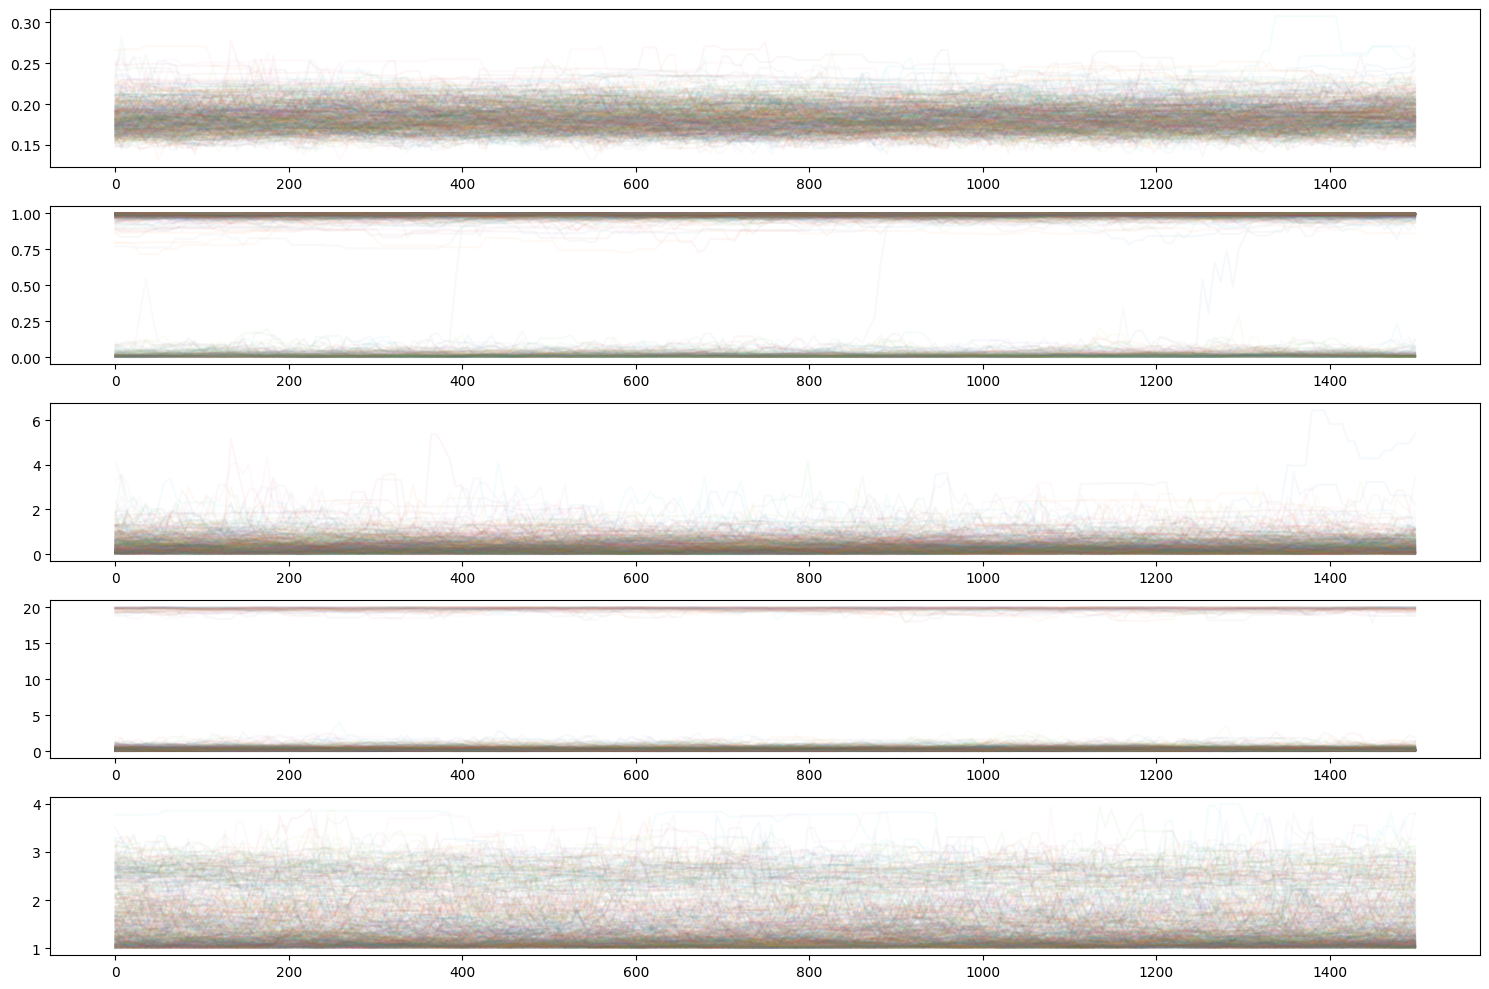

In [10]:
with chain.dataset() as d:
    W = d.shape[0]     # number of walkers
    S = d.shape[1]     # number of steps
    N = d.shape[2]     # number of paramters
    T = int(S / 200)   # "thinning"
    A = 20 / W
    figure, axes = plt.subplots(figsize = (15, 2 * N), ncols = 1, nrows = N)
    for i, ax in enumerate(axes):
        for j in range(0, W):
            ax.plot(range(0, S, T), d[j, ::T, i], alpha = A)
    plt.tight_layout()
    plt.savefig('plots/MCMCSamples.pdf', dpi = 192)

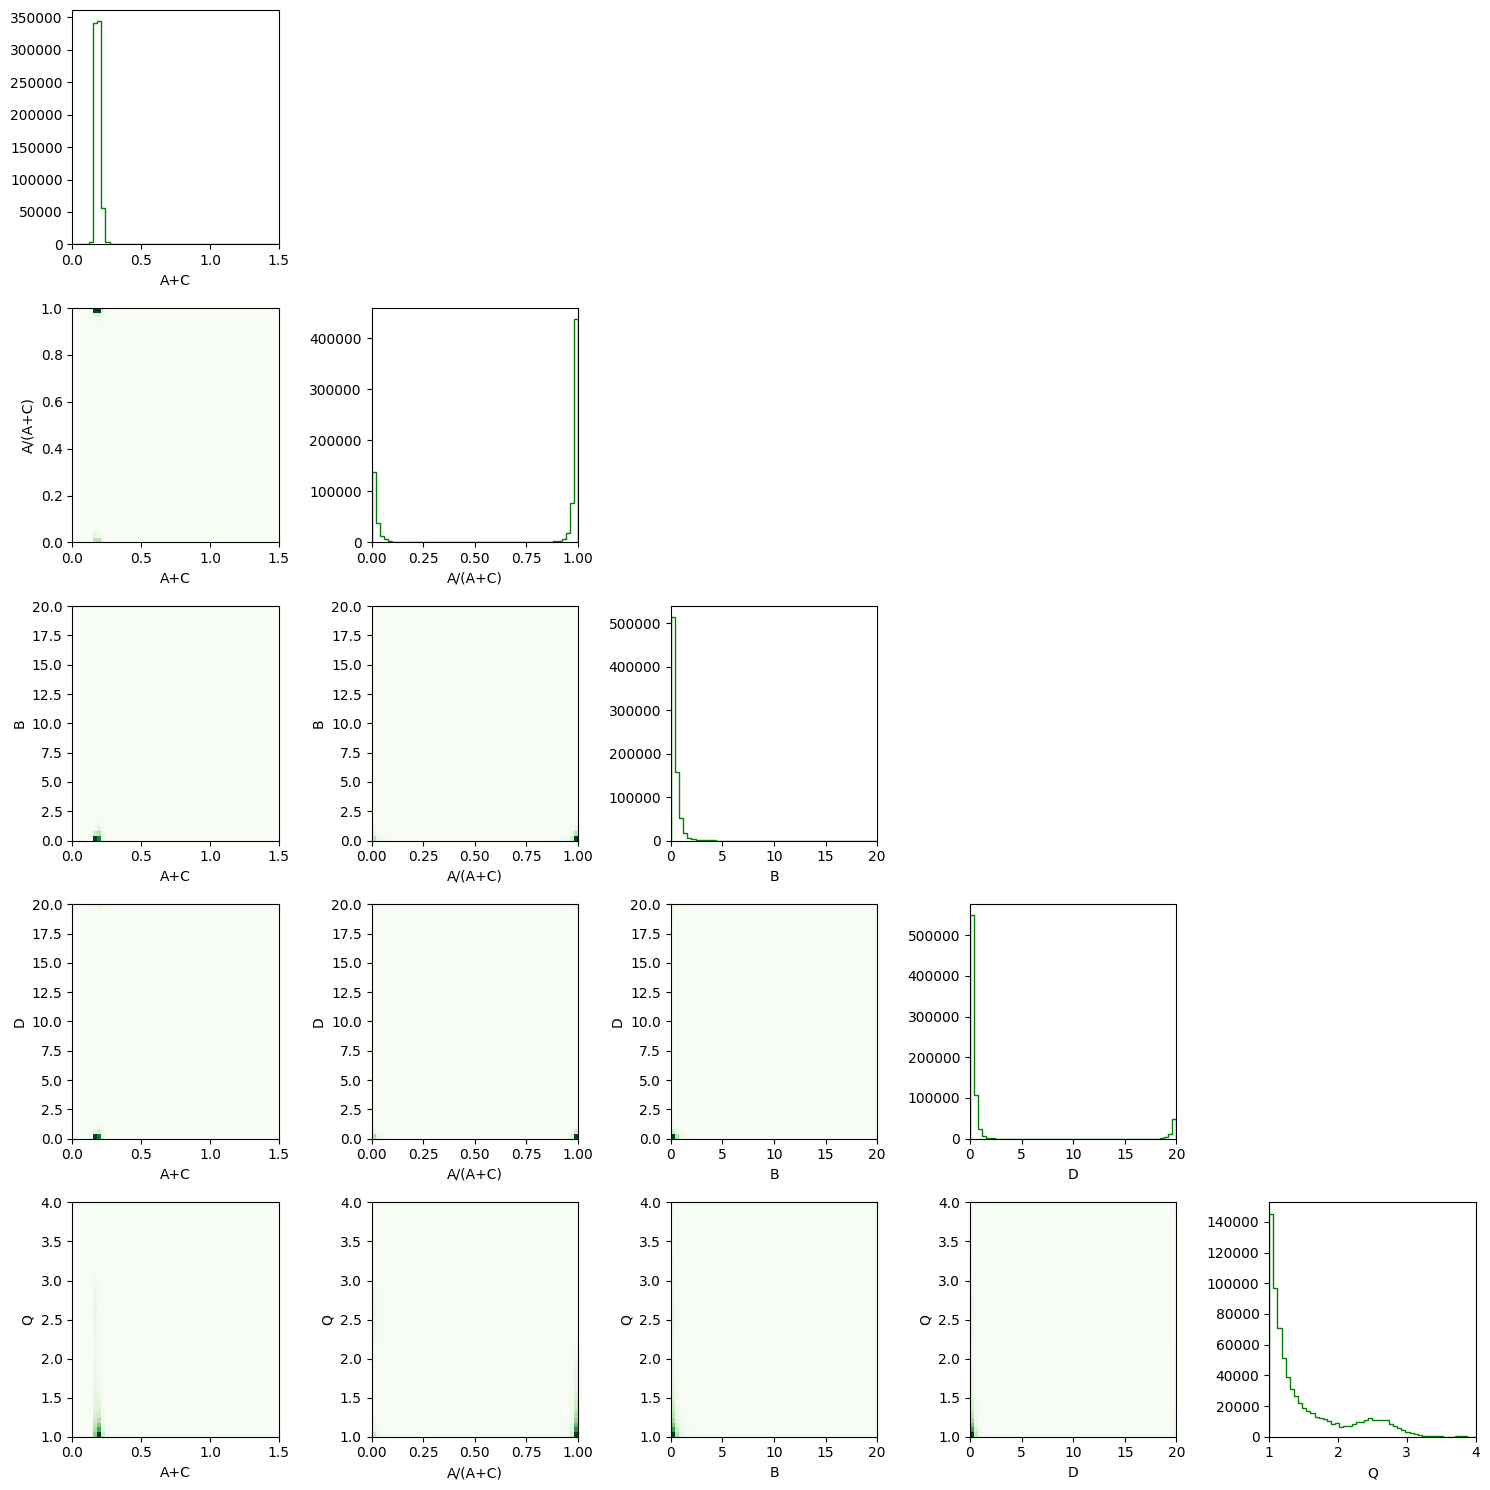

In [11]:
NDimension = len(AllData["labels"])
Ranges = np.array(AllData["ranges"]).T
figure, axes = plt.subplots(figsize = (3 * NDimension, 3 * NDimension), ncols = NDimension, nrows = NDimension)
Names = AllData["labels"]
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if i==j:
            ax.hist(MCMCSamples[:,i], bins=50,
                    range=Ranges[:,i], histtype='step', color='green')
            ax.set_xlabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
        if i>j:
            ax.hist2d(MCMCSamples[:, j], MCMCSamples[:, i], 
                      bins=50, range=[Ranges[:,j], Ranges[:,i]], 
                      cmap='Greens')
            ax.set_xlabel(Names[j])
            ax.set_ylabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
            ax.set_ylim(*Ranges[:,i])
        if i<j:
            ax.axis('off')
plt.tight_layout()
plt.savefig('plots/Correlation.pdf', dpi = 192)
# figure

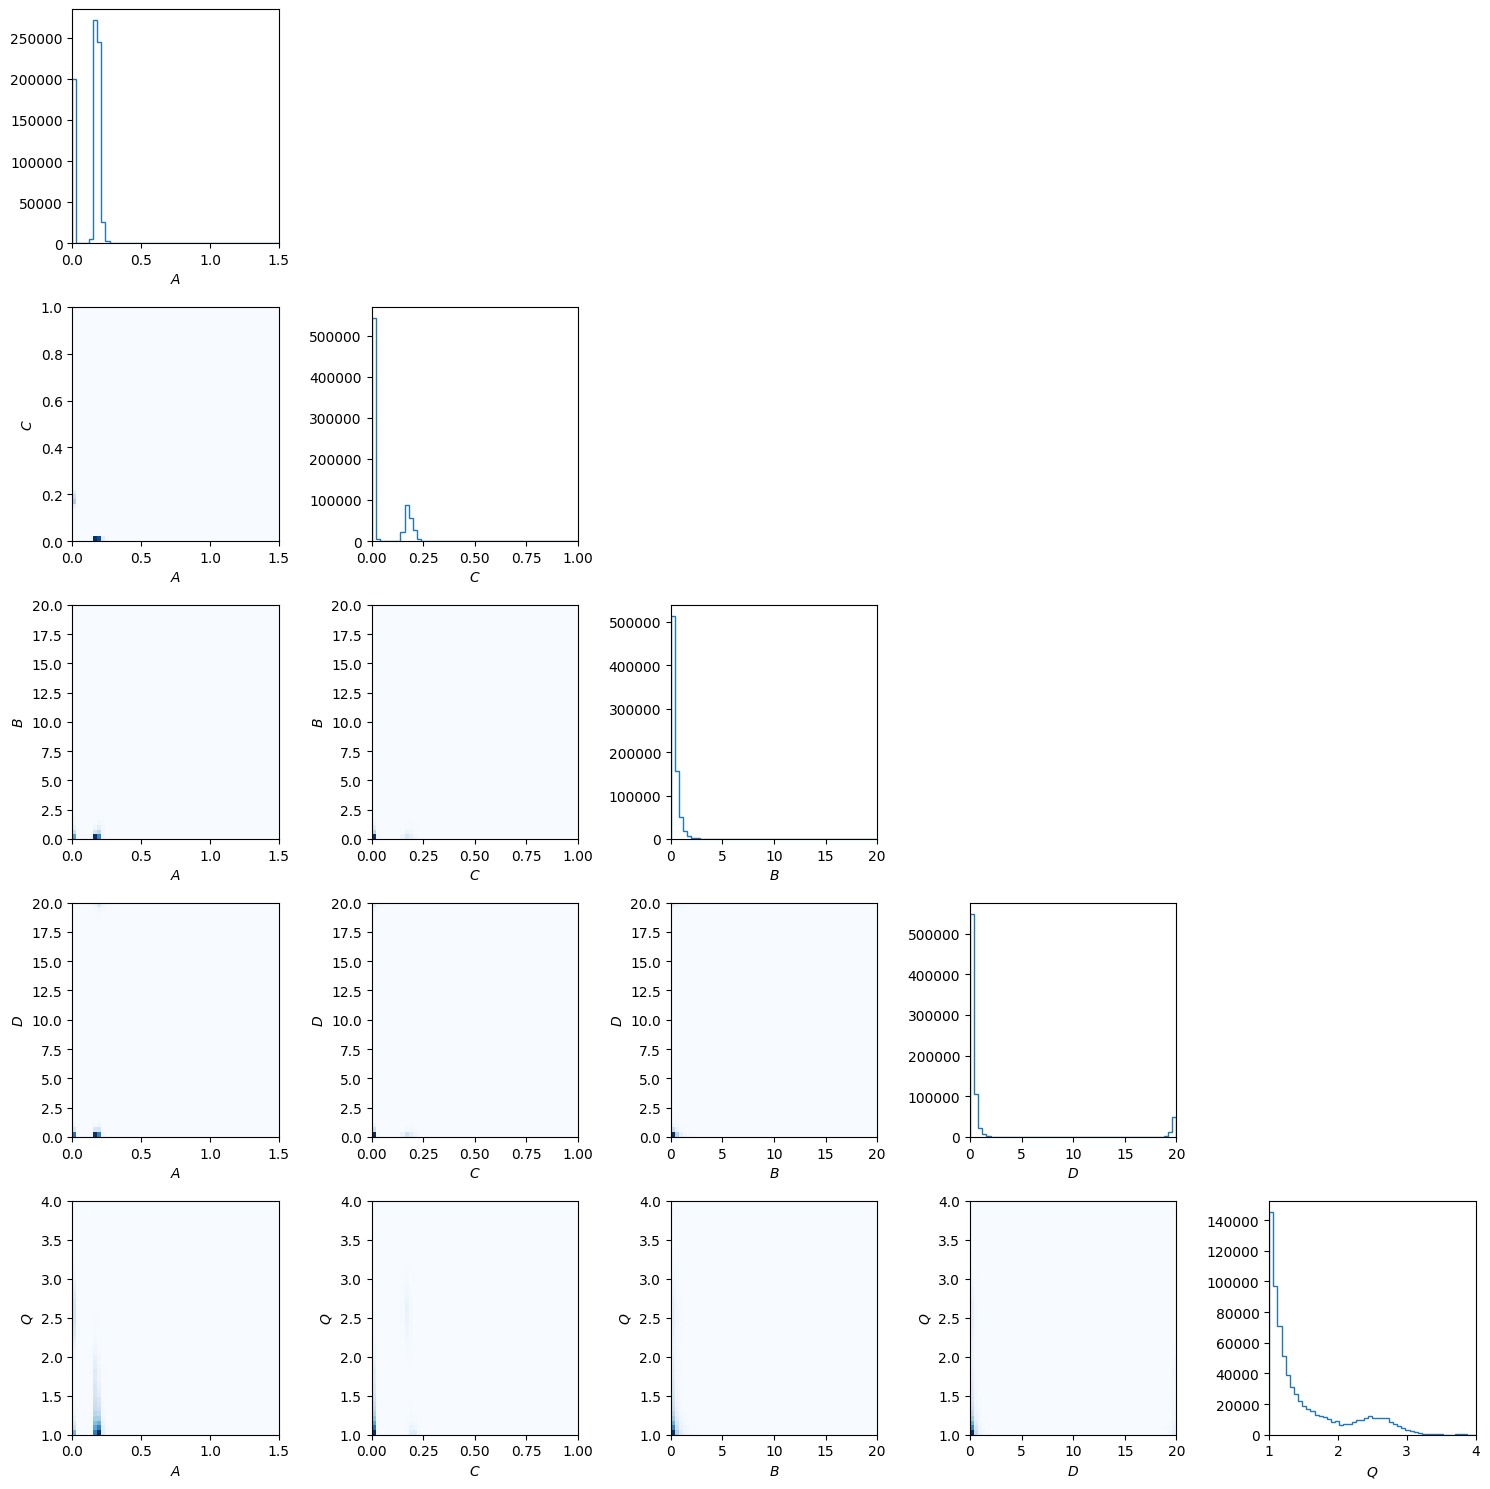

In [12]:
NDimension = 5
Ranges = np.array(AllData["ranges"]).T
figure, axes = plt.subplots(figsize = (15, 15), ncols = NDimension, nrows = NDimension)
Names = [r"$A$", r"$C$", r"$B$", r"$D$", r"$Q$", r"$P_6$"]
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if i==j:
            ax.hist(TransformedSamples[:,i], bins=50,
                    range=Ranges[:,i], histtype='step')
            ax.set_xlabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
        if i>j:
            ax.hist2d(TransformedSamples[:, j], TransformedSamples[:, i], 
                      bins=50, range=[Ranges[:,j], Ranges[:,i]], 
                      cmap='Blues')
            ax.set_xlabel(Names[j])
            ax.set_ylabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
            ax.set_ylim(*Ranges[:,i])
        if i<j:
            ax.axis('off')
plt.tight_layout()
plt.savefig('plots/TransformedCorrelation.pdf', dpi = 192)
# figure

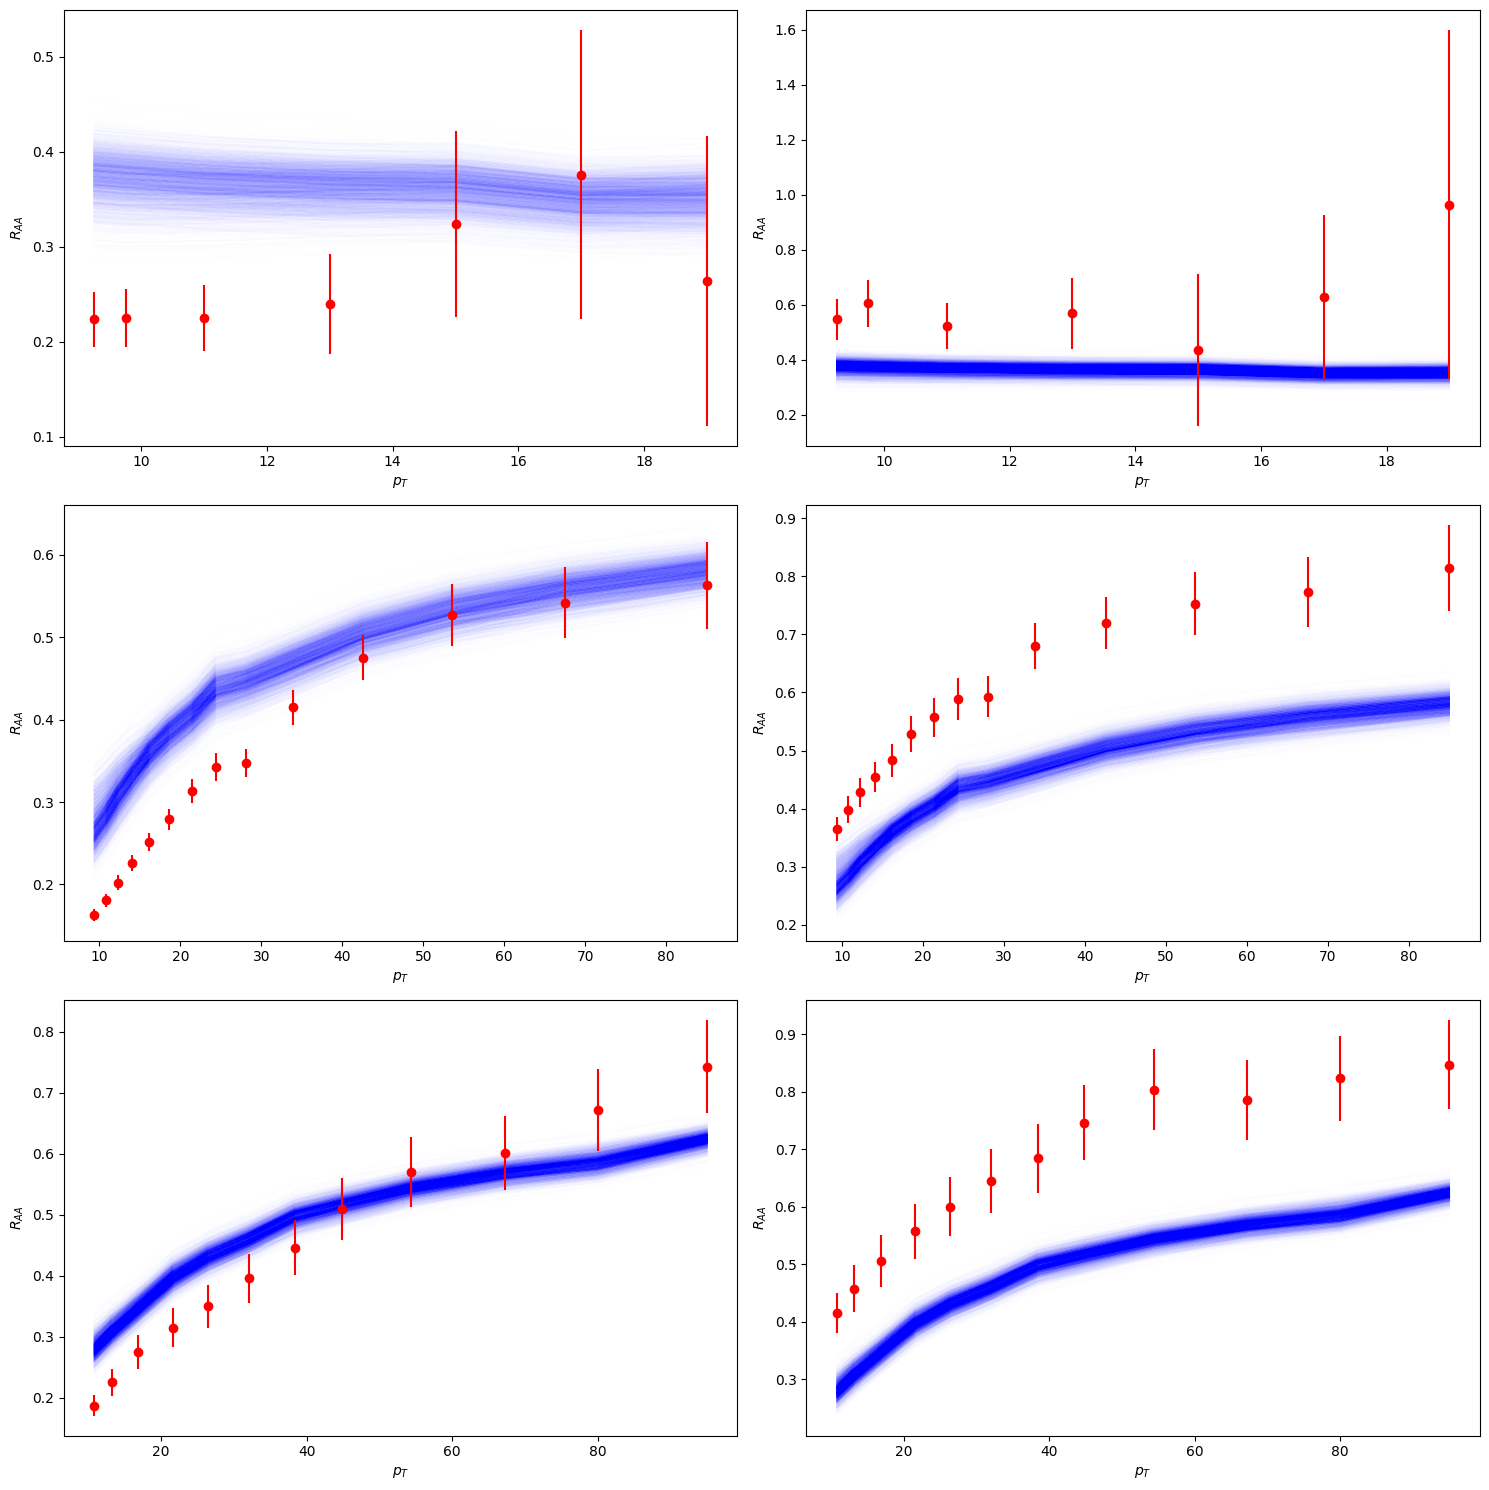

In [13]:
Examples = MCMCSamples[ np.random.choice(range(len(MCMCSamples)), 2500), :]

TempPrediction = {"AuAu200": EmulatorAuAu200.predict(Examples),
                 "PbPb2760": EmulatorPbPb2760.predict(Examples),
                 "PbPb5020": EmulatorPbPb5020.predict(Examples)}

SystemCount = len(AllData["systems"])

figure, axes = plt.subplots(figsize = (15, 5 * SystemCount), ncols = 2, nrows = SystemCount)

for s1 in range(0, SystemCount):
    for s2 in range(0, 2):
        axes[s1][s2].set_xlabel(r"$p_{T}$")
        axes[s1][s2].set_ylabel(r"$R_{AA}$")
        
        S1 = AllData["systems"][s1]
        O  = AllData["observables"][0][0]
        S2 = AllData["observables"][0][1][s2]
        
        DX = AllData["data"][S1][O][S2]['x']
        DY = AllData["data"][S1][O][S2]['y']
        DE = np.sqrt(AllData["data"][S1][O][S2]['yerr']['stat'][:,0]**2 + AllData["data"][S1][O][S2]['yerr']['sys'][:,0]**2)
                
        for i, y in enumerate(TempPrediction[S1][O][S2]):
            axes[s1][s2].plot(DX, y, 'b-', alpha=0.005, label="Posterior" if i==0 else '')
        axes[s1][s2].errorbar(DX, DY, yerr = DE, fmt='ro', label="Measurements")

plt.tight_layout()
figure.savefig('plots/ObservablePosterior.pdf', dpi = 192)
# figure

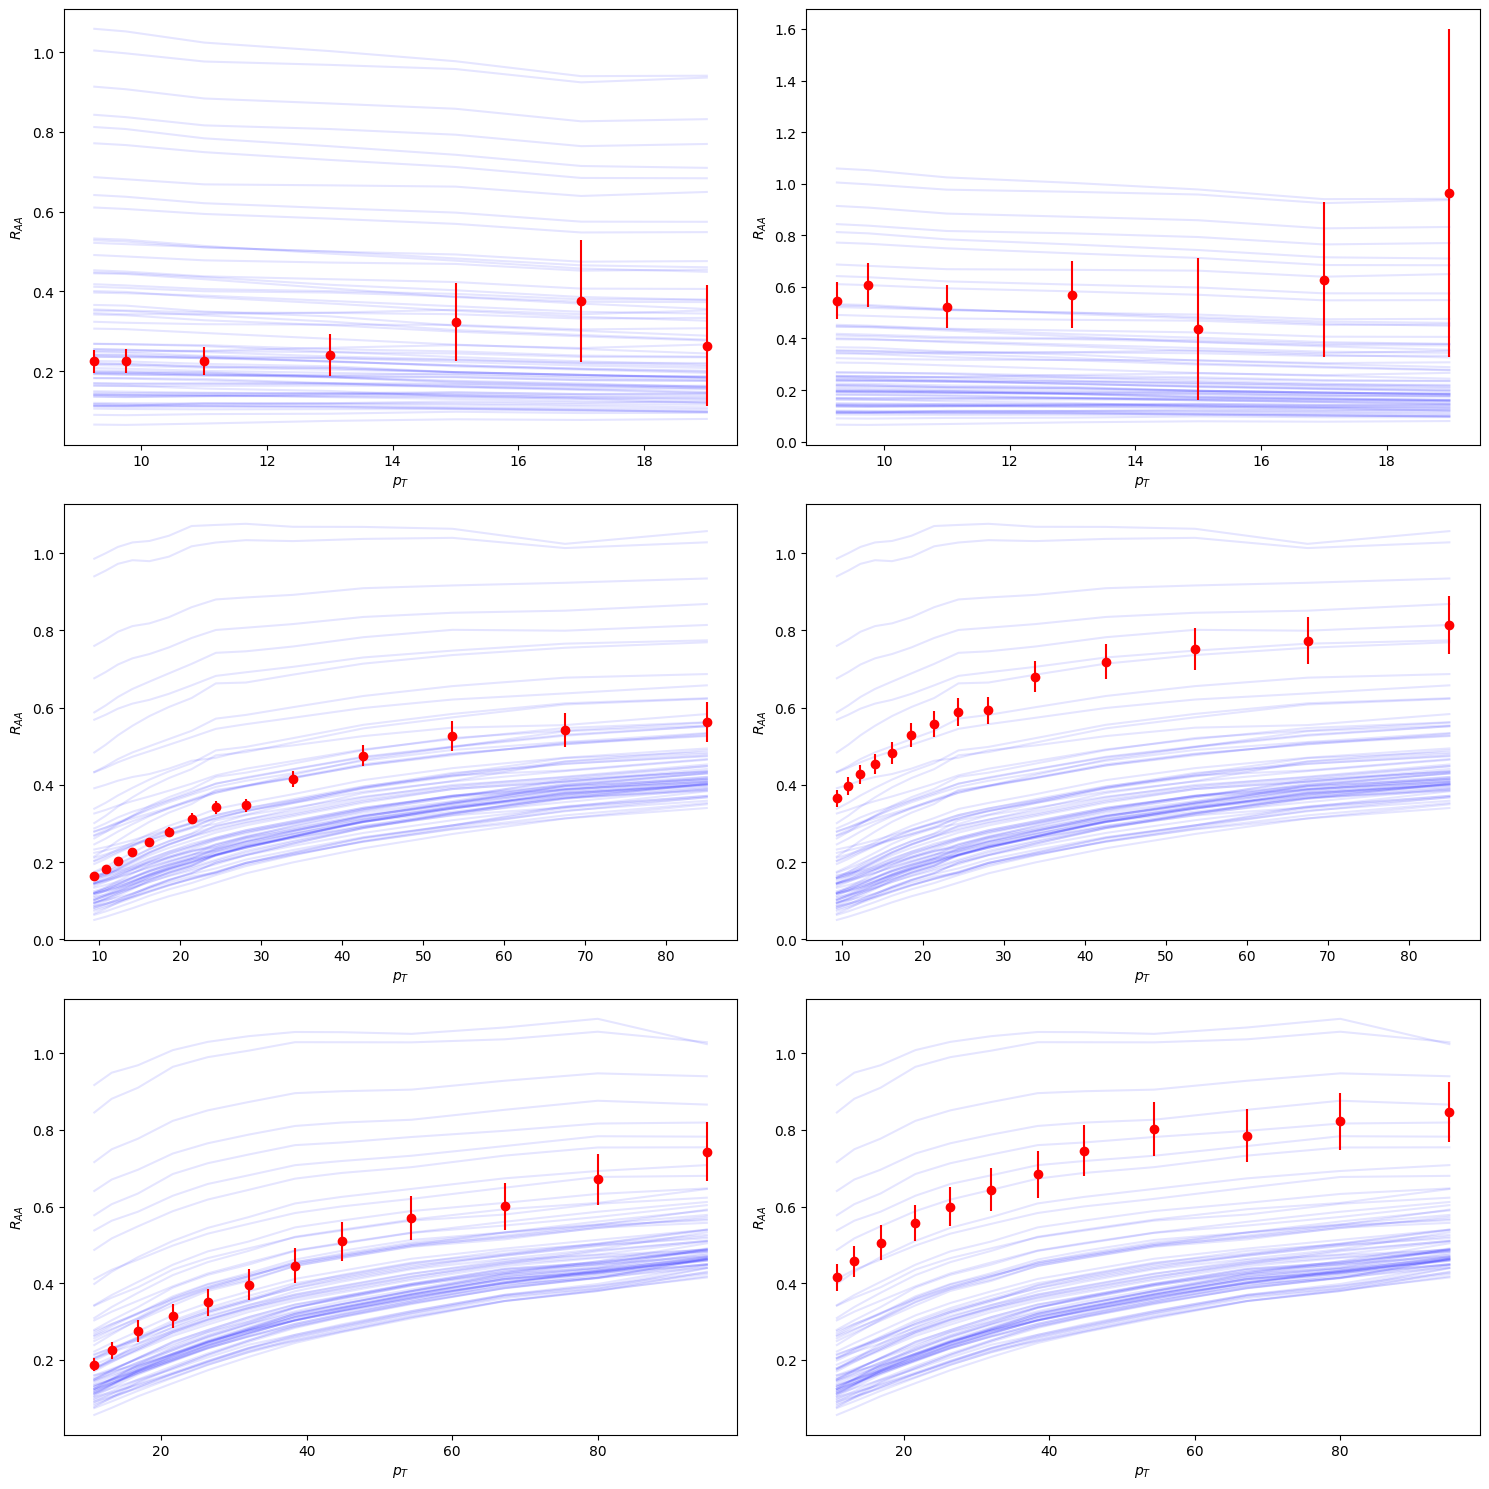

In [14]:
Examples = AllData["design"]

TempPrediction = {"AuAu200": EmulatorAuAu200.predict(Examples),
                 "PbPb2760": EmulatorPbPb2760.predict(Examples),
                 "PbPb5020": EmulatorPbPb5020.predict(Examples)}

SystemCount = len(AllData["systems"])

figure, axes = plt.subplots(figsize = (15, 5 * SystemCount), ncols = 2, nrows = SystemCount)

for s1 in range(0, SystemCount):
    for s2 in range(0, 2):
        axes[s1][s2].set_xlabel(r"$p_{T}$")
        axes[s1][s2].set_ylabel(r"$R_{AA}$")
        
        S1 = AllData["systems"][s1]
        O  = AllData["observables"][0][0]
        S2 = AllData["observables"][0][1][s2]
        
        DX = AllData["data"][S1][O][S2]['x']
        DY = AllData["data"][S1][O][S2]['y']
        DE = np.sqrt(AllData["data"][S1][O][S2]['yerr']['stat'][:,0]**2 + AllData["data"][S1][O][S2]['yerr']['sys'][:,0]**2)
                
        for i, y in enumerate(TempPrediction[S1][O][S2]):
            axes[s1][s2].plot(DX, y, 'b-', alpha=0.1, label="Posterior" if i==0 else '')
        axes[s1][s2].errorbar(DX, DY, yerr = DE, fmt='ro', label="Measurements")

plt.tight_layout()
figure.savefig('plots/PredictedDesign.pdf', dpi = 192)
# figure

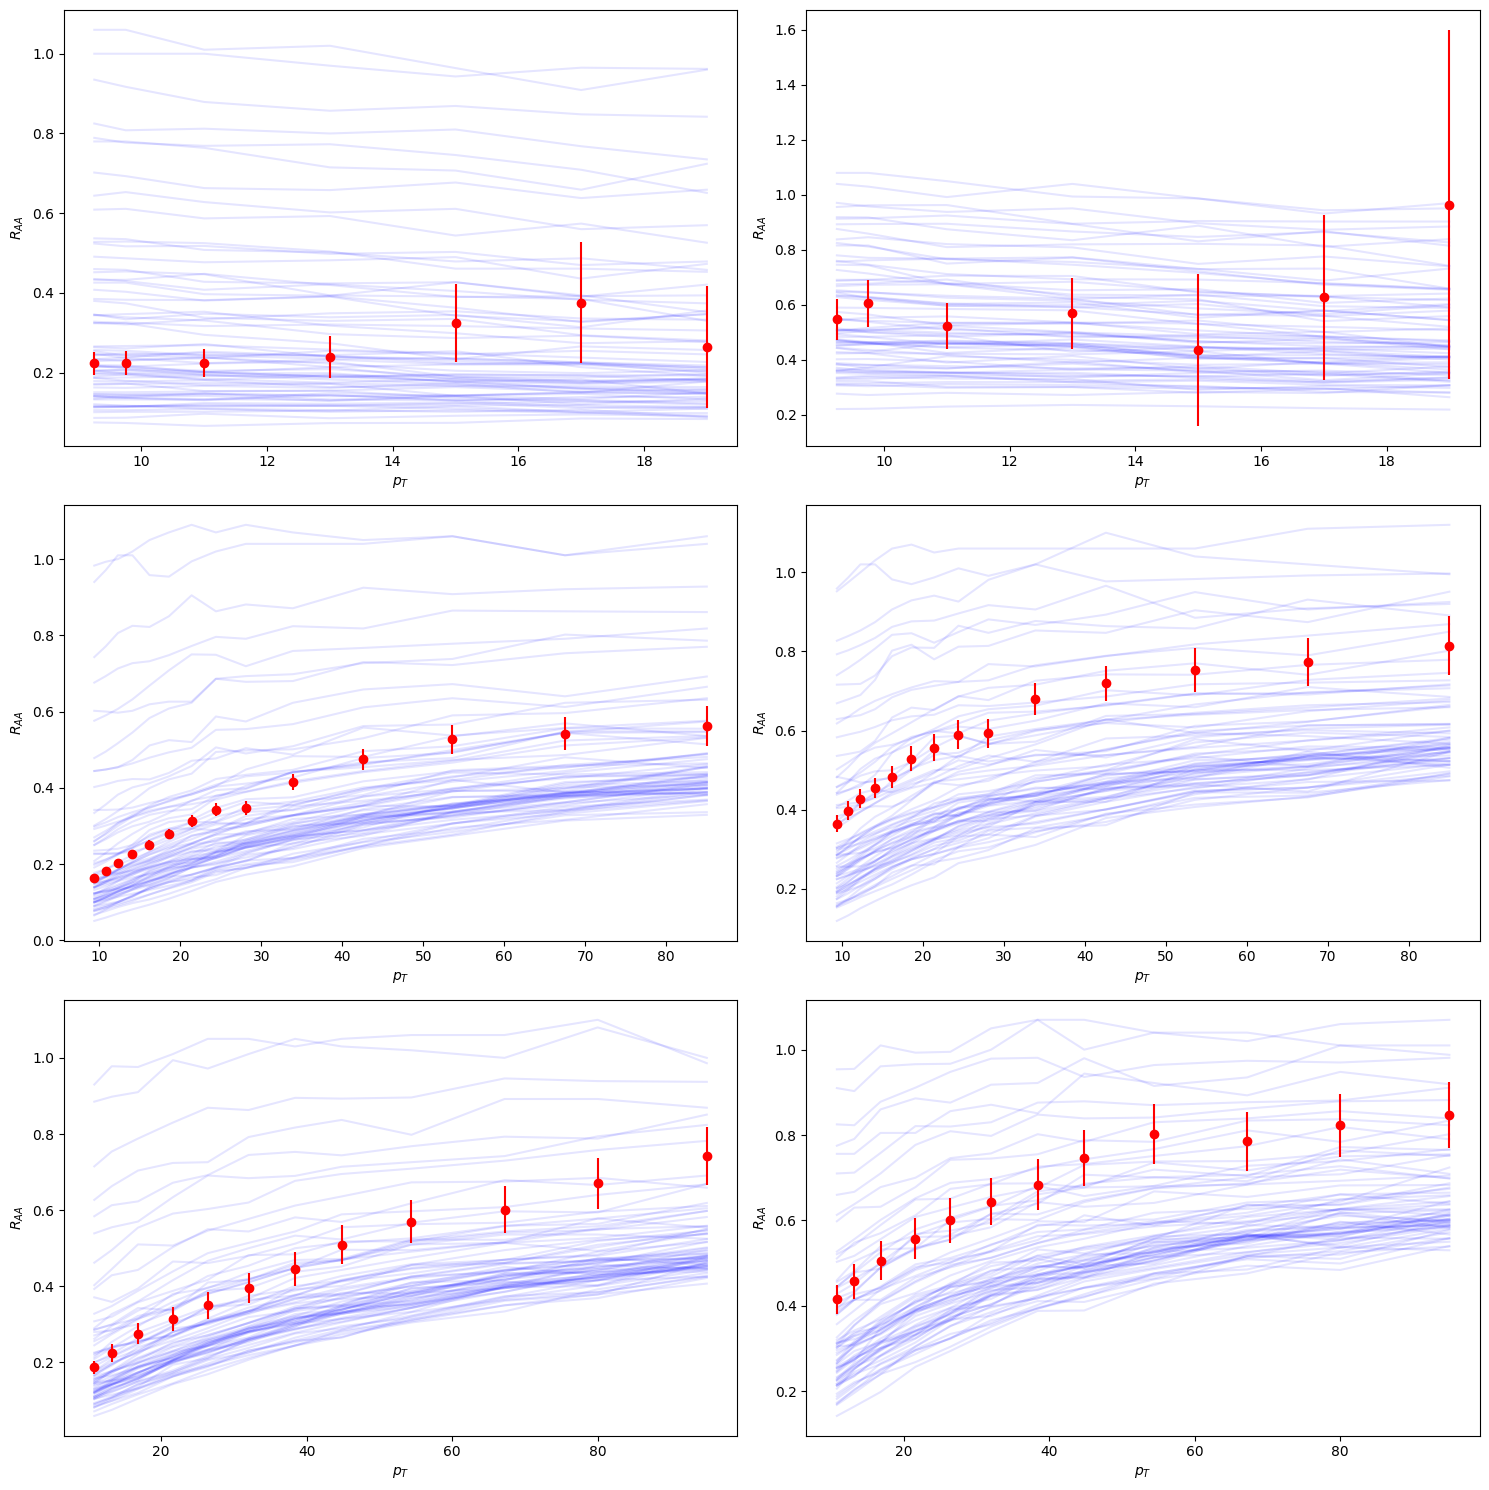

In [15]:
TempPrediction = AllData["model"]

SystemCount = len(AllData["systems"])

figure, axes = plt.subplots(figsize = (15, 5 * SystemCount), ncols = 2, nrows = SystemCount)

for s1 in range(0, SystemCount):
    for s2 in range(0, 2):
        axes[s1][s2].set_xlabel(r"$p_{T}$")
        axes[s1][s2].set_ylabel(r"$R_{AA}$")
        
        S1 = AllData["systems"][s1]
        O  = AllData["observables"][0][0]
        S2 = AllData["observables"][0][1][s2]
        
        DX = AllData["data"][S1][O][S2]['x']
        DY = AllData["data"][S1][O][S2]['y']
        DE = np.sqrt(AllData["data"][S1][O][S2]['yerr']['stat'][:,0]**2 + AllData["data"][S1][O][S2]['yerr']['sys'][:,0]**2)
                
        for i, y in enumerate(TempPrediction[S1][O][S2]['Y']):
            axes[s1][s2].plot(DX, y, 'b-', alpha=0.1, label="Posterior" if i==0 else '')
        axes[s1][s2].errorbar(DX, DY, yerr = DE, fmt='ro', label="Measurements")

plt.tight_layout()
figure.savefig('plots/Design.pdf', dpi = 192)
# figure

In [16]:
# close all plots to save memory
plt.close('all')